In [200]:
import pickle5 as pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import warnings

warnings.filterwarnings('ignore')

### Analysis Source Data

In [107]:
%%time
df_original = pd.read_csv('data/source_data_for_analysis_v1.csv')
df_synthetic = pd.read_csv('data/samples_gan_for_analysis__fk_1.csv')

CPU times: user 2.25 s, sys: 23.8 ms, total: 2.27 s
Wall time: 2.27 s


##### Get geocode and forex maps

In [108]:
ADD_GEO_MAP = pickle.load(open('models/add_to_geo_map.pkl', 'rb'))
FOREX = pickle.load(open("models/exchange_rates.pkl", "rb"))

In [109]:
# %%time
# df['usd_amt'] = df[['33b_orig_ord_amt', '33b_cur']].apply(lambda x: x[0] * FOREX[x[1]], axis = 1)

In [110]:
def geo_loc(point = None, address = None):
    
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="map.app")
    
    if address is None:
        try:
            location = geolocator.reverse(point)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid geo-coordinates !!'
    else:
        try:
            location = geolocator.geocode(address)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid Address !!'

##### Data Visualisation

In [111]:
from collections import OrderedDict
def get_top_remitters(df, n = 100):
    return OrderedDict(sorted(
        (df.groupby(['50f_payor_add_ln_2'])['usd_amt'].sum() / df.groupby(['50f_payor_add_ln_2'])['usd_amt'].count())
            .to_dict().items(), key=lambda x: x[1], reverse=True)[:n])

In [112]:
def get_top_beneficiaries(df, n = 100):
    return OrderedDict(sorted(
        (df.groupby(['59f_ben_add_ln_2'])['usd_amt'].sum() / df.groupby(['59f_ben_add_ln_2'])['usd_amt'].count())
        .to_dict().items(), key=lambda x: x[1], reverse=True)[:n])

low : 0.8; high: 1.0


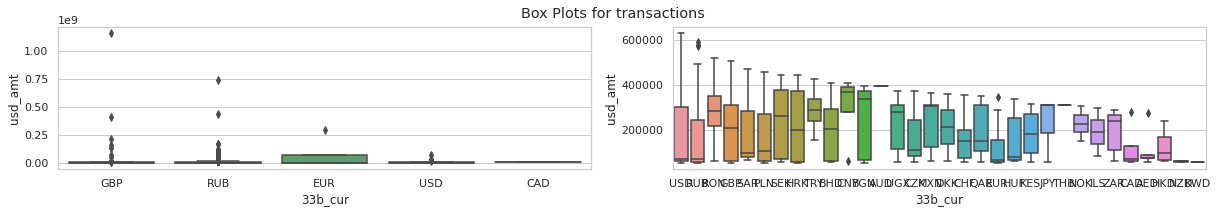

low : 0.6000000000000001; high: 0.8


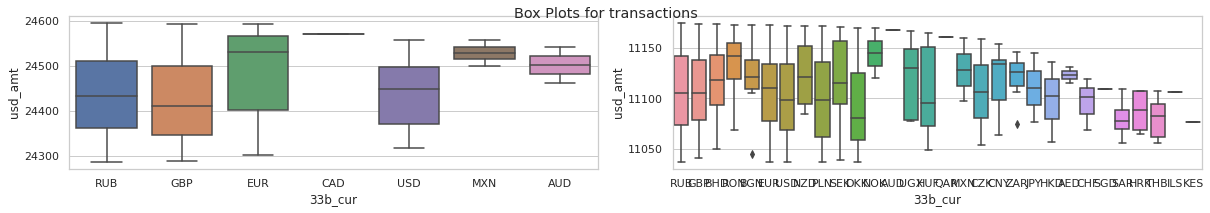

low : 0.39999999999999997; high: 0.6


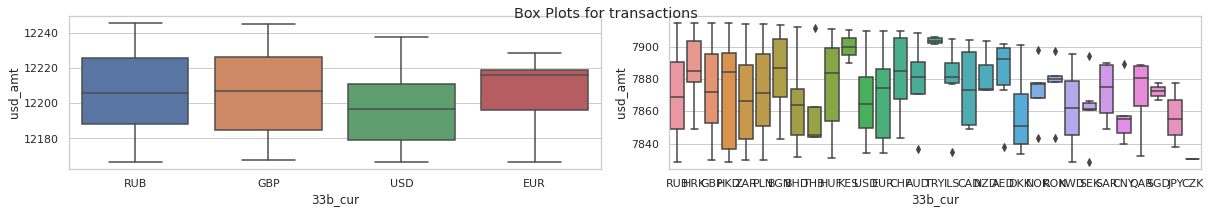

low : 0.2; high: 0.4


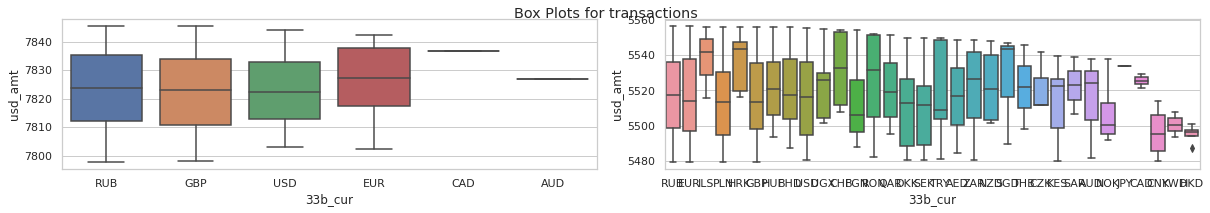

low : 0.0; high: 0.2


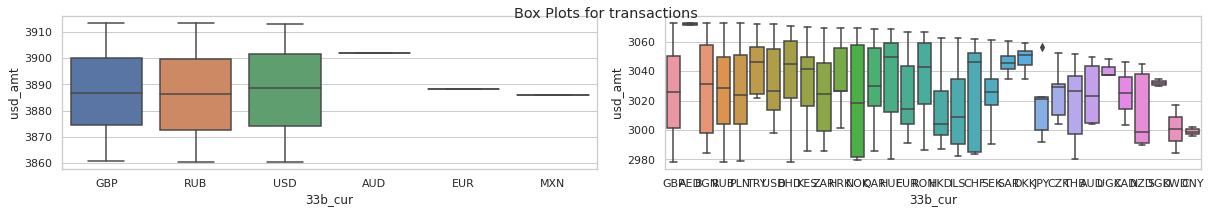

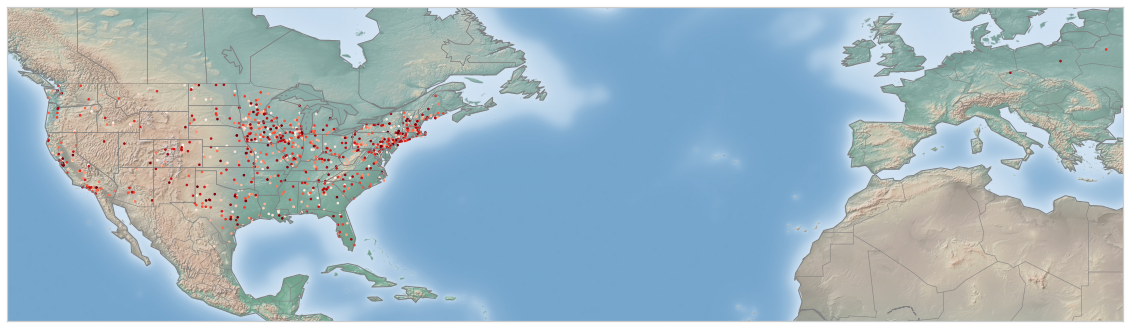

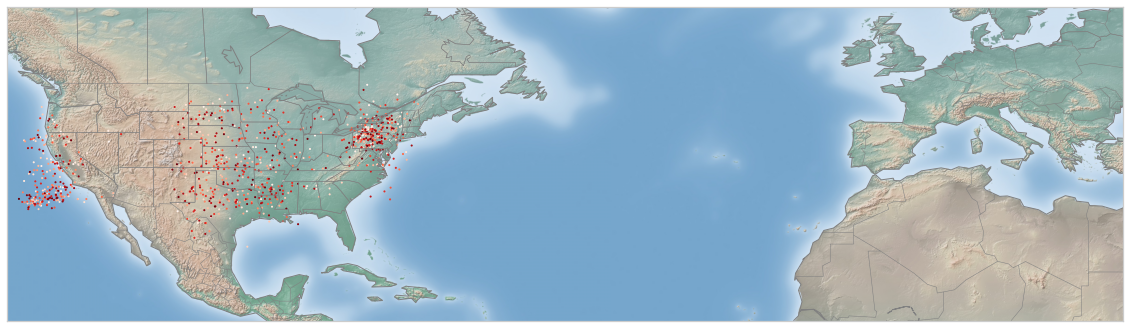

In [113]:
import importlib
import data_analyser
importlib.reload(data_analyser)

from data_analyser import DataAnalyser

dan = DataAnalyser(df_original, df_synthetic)
dan.plot_transaction_distribution(bins = 5, value_col = 'usd_amt')
dan.plot_analysis(lower = 0.8, transactor = 'target', value_col = 'usd_amt')

In [114]:
def get_lat_long(address):
    try:
        point_ = ADD_GEO_MAP[address.strip()]
        return point_['latitude'], point_['longitude']
    except:
        point_ = geo_loc(address = address.strip())
        return point_[2]['lat'], point_[2]['lon']
    else:
        return 0, 0

In [115]:
%%time
# Extract the data we're interested in
toppers = get_top_remitters(df_original, 2000)
keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
point = [get_lat_long(key) for key in keys]
lat = np.array(point, dtype='float32')[:, 0].tolist()
lon = np.array(point, dtype='float32')[:, 1].tolist()
amount = [toppers[x] for x in keys]

CPU times: user 109 ms, sys: 29 µs, total: 109 ms
Wall time: 108 ms


In [116]:
%%time
# Extract the data we're interested in
toppers = get_top_beneficiaries(df_original, 2000)
keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
point = [get_lat_long(key) for key in keys]
lat = np.array(point, dtype='float32')[:, 0].tolist()
lon = np.array(point, dtype='float32')[:, 1].tolist()
amount = [toppers[x] for x in keys]
min_, max_ = np.log10(np.array(amount)).min(), np.log10(np.array(amount)).max()

CPU times: user 122 ms, sys: 66 µs, total: 122 ms
Wall time: 120 ms


In [170]:
def plot_transaction_curve(ax, df, group_key, value_col):
    sum_ = 0.
    arr_ = []
    
    amount_list = sorted(df.groupby([group_key])[value_col].sum().to_dict().items(), key = lambda x: x[1], reverse = True)
    SUM = np.array(np.array(amount_list)[:, 1], dtype='float').sum()
    
    for x in np.array(np.array(amount_list)[:, 1], dtype='float'):
        sum_ += x
        arr_.append(sum_/SUM)
    
    np.array(np.array(amount_list)[:, 1], dtype='float')
    ax.plot(arr_)

In [197]:
def get_transaction_plots(df, ax):
    toppers = get_top_remitters(df, 2000)
    keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
    point = [get_lat_long(key) for key in keys]
    lat = np.array(point, dtype='float32')[:, 0].tolist()
    lon = np.array(point, dtype='float32')[:, 1].tolist()
    amount = [toppers[x] for x in keys]

    plot_transaction_curve(ax, df, '50f_payor_add_ln_2', 'usd_amt')
    # ax.annotate('inflection point', xy=(700, .6), xytext=(1500, 0.2),
    #     # arrowprops=dict(arrowstyle="wedge, tail_width=1", alpha=1))
    #     # arrowprops=dict(facecolor='red', shrink=0.15))
    #     arrowprops=dict(facecolor='red', shrink=0.07))
    # ax.annotate('(500, 0.65)', xy=(700, .6), xytext=(1000, 0.49))
    ax.set_title('Remittance Curve')
    ax.set_xlabel('Number of Payors')
    ax.set_ylabel('Percentage Amount Transferred')

    
    
    toppers = get_top_beneficiaries(df, 2000)
    keys = [key for key in toppers.keys() if key.strip() in ADD_GEO_MAP.keys()]
    point = [get_lat_long(key) for key in keys]
    lat = np.array(point, dtype='float32')[:, 0].tolist()
    lon = np.array(point, dtype='float32')[:, 1].tolist()
    amount = [toppers[x] for x in keys]

    plot_transaction_curve(ax, df, '59f_ben_add_ln_2', 'usd_amt')
    # ax.annotate('inflection point', xy=(700, .6), xytext=(1500, 0.2),
    #     # arrowprops=dict(arrowstyle="wedge, tail_width=1", alpha=1))
    #     # arrowprops=dict(facecolor='red', shrink=0.15))
    #     arrowprops=dict(facecolor='red', shrink=0.07))
    # ax.annotate('(500, 0.65)', xy=(700, .6), xytext=(1000, 0.49))
    ax.set_title('Remittance Curve')
    ax.set_xlabel('Number of Beneficiaries')
    ax.set_ylabel('Percentage Amount Received')

CPU times: user 826 ms, sys: 4.03 ms, total: 830 ms
Wall time: 827 ms


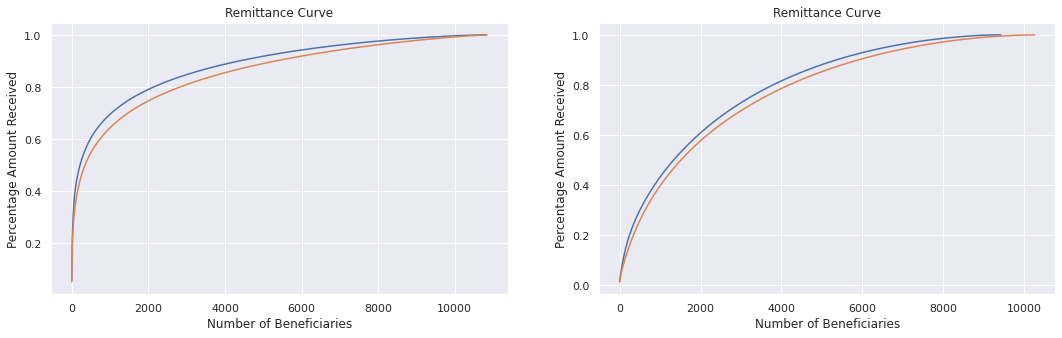

In [199]:
%%time
%matplotlib inline

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

ax = axes.flat[0]
get_transaction_plots(df_original, ax)


ax = axes.flat[1]
get_transaction_plots(df_synthetic, ax)


##### Univariate Analysis

In [ ]:
def attr_plot(data, samples, discrete = None, numeric = None):
    sns.set(style='whitegrid')
    if discrete is None:
        for col in numeric:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.distplot(data[col], bins=100, hist_kws={'alpha': 0.7})
            plt.subplot(122)
            sns.distplot(samples[col], bins=100, hist_kws={'alpha': 0.7})
    else:
        for col in discrete:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.countplot(x=col, data=data[discrete])
            plt.xticks(rotation=45)
            plt.subplot(122)
            sns.countplot(x=col, data=samples[discrete])
            plt.xticks(rotation=45)

##### Bivariate Plot

In [ ]:
def corrplot(data, samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(data.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues", vmin = -0.5, vmax = 0.5)
    
    plt.subplot(122)
    sns.heatmap(samples.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues", vmin = -0.5, vmax = 0.5)

In [ ]:
discrete = ['33b_cur', 'src_xfrr_type', 'charge_dtls', 'charge_dtls_cur']
numeric = ['usd_amt', 'src_lon', 'src_lat', 'target_lat', 'target_lon', 
           'charge_dtls_amt']
neg_cond = True

In [ ]:
%time
if neg_cond:
    corrplot(df_original[df_original['src_xfrr_type'] != 'A'][df_synthetic.columns], df_synthetic)

In [ ]:
%time
if neg_cond:
    attr_plot(df_original[df_original['src_xfrr_type'] != 'A'], 
              df_synthetic, discrete = discrete)
    attr_plot(df_original[df_original['src_xfrr_type'] != 'A'], 
              df_synthetic, numeric = numeric)
else:
    attr_plot(df_original[df_original['src_xfrr_type'] == 'A'], 
              df_synthetic, discrete = discrete)
    attr_plot(df_original[df_original['src_xfrr_type'] == 'A'], 
              df_synthetic, numeric = numeric)

##### Multivariate Analysis

##### KL Divergence

##### PCA Analysis - Information Loss